**Este empieza donde acabó el notebook fastai_2.ipynb**

## Pruebas:
1. Entrenar con 1,2,3 vs 4.
2. Entrenar 2 vs 3,4
3. 1vs4,  2vs4, 3vs4  (I.e, 4 vs all)
4. 1vs all --> igual que el pto 3  -->  1vs2, 1vs3, 1vs4

In [6]:
# https://walkwithfastai.com/tab.clas.binary
from fastai.tabular.all import *

DS = '/home/javier/mis_proyectos/calculos_Fer/DATAJAVI_V5_deuce.csv'
DS = '/home/javier/mis_proyectos/calculos_Fer/DATAJAVI_V5_ad.csv'

### FASTAI:
df = pd.read_csv(DS)

print("clases: ", pd.unique(df.Efectividad))

def get_filtered_dfs(df):
    df1 = df[df.Efectividad==1].copy() # ace
    df2 = df[df.Efectividad==2].copy() # 2 golpes, falla el restador
    df3 = df[df.Efectividad==3].copy() # 3 el sacador gana con 4 golpes o menos
    df4 = df[df.Efectividad==4].copy() # lo gana el sacador, pero más de 4 golpes. No tiene influencia --> todos los que no son 1, 2 o 3
    ### los 3 primeros son efectivos. I.e., el saque tiene influencia importante.
    return df1, df2, df3, df4

### 1. Entrenar con 1_2_3 vs 4.
df1,df2,df3,df4 = get_filtered_dfs(df)
df2.Efectividad = 1
df3.Efectividad = 1
df_1_2_3_vs_4 = pd.concat([df1, df2, df3, df4])

### 2. Entrenar 2 vs 3_4
df1, df2, df3, df4 = get_filtered_dfs(df)  # refresh dfs
df3.Efectividad = 4
df_2_vs_3_4 = pd.concat([df2, df3, df4])

### 3. 1vs4,  2vs4, 3vs4  (I.e, 4 vs all)
df1, df2, df3, df4 = get_filtered_dfs(df)  # refresh dfs
df_1_4 = pd.concat([df1,df4])
df_2_4 = pd.concat([df2,df4])
df_3_4 = pd.concat([df3,df4])

### 4. 1vs all --> igual que el pto 3  -->  1vs2, 1vs3, 1vs4
df_1_2 = pd.concat([df1,df4])
df_1_3 = pd.concat([df2,df4])
# df_1_4 = pd.concat([df3,df4])  # already done

# ***APScoreBinary:*** Average Precision for single-label binary classification problems  
# ***APScoreMulti:***  Average Precision for multi-label classification problems

cat_names = ['DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T']
cont_names = ['V(km/h)', '[YA]', 'ZA', 'Znet', 'TIME', 'difV', '&(grados)', 'ANG. IN', 'dLinea']
y_names = ['Efectividad']


def train(df, final_epochs, metric, patience, cat_names, cont_names, y_names):
    """metric: metric to monitor at last training"""
    cat = Categorify()
    to = TabularPandas(df, cat, cat_names)
    cats = to.procs.categorify
    norm = Normalize()
    
    splits = RandomSplitter(valid_pct=0.3)(range_of(df))
    procs = [Categorify, FillMissing, Normalize]
    
    procs = [Categorify, FillMissing, Normalize]
    y_names = 'Efectividad'
    y_block = CategoryBlock()
    to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                       y_names=y_names, y_block=y_block, splits=splits)
    
    dls = to.dataloaders(bs=1024)
    # learn = tabular_learner(dls, [256, 128, 128, 64], loss_func=FocalLossFlat(), metrics=[accuracy]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
    # learn = tabular_learner(dls, [200,100], metrics=[accuracy, BalancedAccuracy(), Recall(), Precision(), APScoreMulti()]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
    learn = tabular_learner(dls, [200,100], metrics=[accuracy, BalancedAccuracy()]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
    
    ###
    # lr = 9e-3
    lr = learn.lr_find().valley
    learn.lr = lr/5
    print("\nCalculated Lrt: ", lr, "using: ", learn.lr)
    learn.fit_one_cycle(1, slice(lr/(2.6**4),lr))#, moms=(0.8,0.7))
    learn.freeze_to(-2)
    learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))
    learn.unfreeze()
    
    learn.lr = learn.lr*5
    print("\nLearning Rate: ", learn.lr)
    learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))
    
    keep_path = learn.path
    learn.path = Path('/home/javier/mis_proyectos/')
    
    # set the model path to a writeable directory. If you don't do this, the code will produce an error on Gradient
    # learn.path = Path(model_path)
    learn.fit_one_cycle(5, slice(1e-4, 8e-3), 
                        cbs=[EarlyStoppingCallback(monitor='balanced_accuracy_score', min_delta=0.0001, patience=3),
                        SaveModelCallback(monitor='balanced_accuracy_score', min_delta=0.01)])
    
    learn.fit_one_cycle(final_epochs, slice(8e-4, 8e-3),
                        cbs=[EarlyStoppingCallback(monitor=metric, min_delta=0.001, patience=patience),
                        SaveModelCallback(monitor=metric, min_delta=0.01)])
    # learn.fit_one_cycle(12, slice(5e-4, 5e-3))
    
    ### reset the model path
    learn.path = keep_path
    
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.print_classification_report()
    return learn, interp, splits

# Experimentos de entrenamiento - parte 2:
(Parte 1 en fastai_2.ipynb)

Juntando los 4 subsets el modelo entrena regular, así que vamos a probar lo siguiente:  

1. Entrenamiento entrenar con 1,2,3 vs 4


Calculated Lrt:  0.0012022644514217973 using:  0.00024045289028435947


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.740813,0.675547,0.588147,0.526565,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.682445,0.679425,0.594174,0.552769,00:00
1,0.668024,0.667254,0.611251,0.606391,00:00
2,0.660059,0.659582,0.594676,0.603251,00:00



Learning Rate:  0.0012022644514217973


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.644344,0.662172,0.622300,0.620517,00:00
1,0.642149,0.651226,0.597690,0.609133,00:00
2,0.637901,0.645521,0.606228,0.615678,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.631042,0.641602,0.603214,0.589941,00:00
1,0.634493,0.653416,0.579106,0.556836,00:00
2,0.637863,0.683502,0.573079,0.539166,00:00
3,0.634951,0.650719,0.627825,0.587705,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5899406562597707.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.624716,0.636246,0.621296,0.604882,00:00
1,0.622911,0.632695,0.626821,0.609812,00:00
2,0.621271,0.636368,0.612255,0.594458,00:00
3,0.620894,0.645556,0.586138,0.560277,00:00
4,0.619623,0.635259,0.609242,0.592186,00:00


Better model found at epoch 0 with accuracy value: 0.6212958097457886.
No improvement since epoch 1: early stopping


              precision    recall  f1-score   support

           1       0.66      0.71      0.68      1154
           4       0.55      0.50      0.53       837

    accuracy                           0.62      1991
   macro avg       0.61      0.60      0.61      1991
weighted avg       0.62      0.62      0.62      1991



((#4647) [5005,4473,5542,3837,2609,4491,2373,4674,5821,782...],
 (#1991) [3952,2951,4742,2957,5114,3004,1430,4360,4861,1909...])

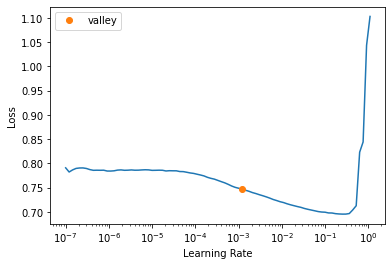

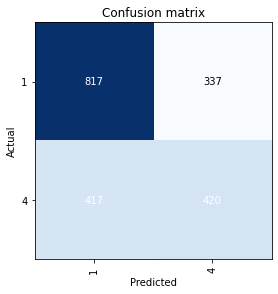

In [7]:
final_epochs, metric, patience = 50, 'accuracy', 3
learn, interp, splits = train(df_1_2_3_vs_4, final_epochs, metric, patience, cat_names, cont_names, y_names)
splits

In [8]:
learn.lr

0.0012022644514217973

2. Entrenamiento de 2 vs 3_4


Calculated Lrt:  0.0010000000474974513 using:  0.00020000000949949026


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.773105,0.698720,0.437045,0.519396,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.714766,0.701660,0.439843,0.519454,00:00
1,0.704847,0.693034,0.512591,0.528370,00:00
2,0.697713,0.691872,0.507555,0.515345,00:00



Learning Rate:  0.0010000000474974513


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.682988,0.692971,0.530498,0.530026,00:00
1,0.678182,0.689661,0.522104,0.509633,00:00
2,0.673004,0.684964,0.556799,0.533337,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.662859,0.681410,0.579743,0.510048,00:00
1,0.662566,0.654565,0.636262,0.532334,00:00
2,0.648081,0.653561,0.655848,0.536688,00:00
3,0.632086,0.638471,0.658646,0.518008,00:00
4,0.619544,0.631557,0.667599,0.515631,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5100484194285514.
Better model found at epoch 1 with balanced_accuracy_score value: 0.5323339216522801.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.612240,0.651465,0.635702,0.526997,00:00
1,0.607675,0.647415,0.645775,0.525432,00:00
2,0.603790,0.651899,0.642417,0.526940,00:00
3,0.600637,0.647288,0.657527,0.528044,00:00
4,0.596251,0.640335,0.650252,0.514874,00:00
5,0.591218,0.641945,0.668159,0.510613,00:00
6,0.586234,0.651411,0.677112,0.533384,00:00
7,0.581588,0.655730,0.671517,0.516995,00:00
8,0.579407,0.669130,0.672636,0.538518,00:00
9,0.578604,0.683687,0.656407,0.515890,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5269966804785254.
Better model found at epoch 8 with balanced_accuracy_score value: 0.53851784535004.
No improvement since epoch 8: early stopping


              precision    recall  f1-score   support

           2       0.44      0.18      0.26       556
           4       0.71      0.89      0.79      1231

    accuracy                           0.67      1787
   macro avg       0.57      0.54      0.52      1787
weighted avg       0.62      0.67      0.62      1787



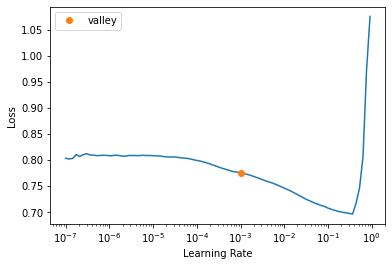

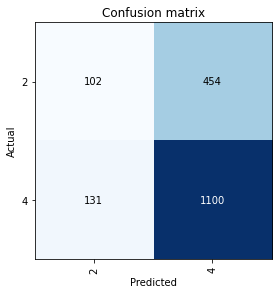

In [9]:
final_epochs, metric, patience = 50, 'balanced_accuracy_score', 3
learn, interp, splits = train(df_2_vs_3_4, final_epochs, metric, patience, cat_names, cont_names, y_names)

3. 1 vs 4,  2 vs 4, 3 vs 4  -->  (I.e, 4 vs all)

############### 
### df_1_4: ### 
###############



Calculated Lrt:  0.0012022644514217973 using:  0.00024045289028435947


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.759835,0.684498,0.596116,0.672878,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.672542,0.681539,0.570874,0.696305,00:00
1,0.630362,0.676845,0.586408,0.721529,00:00
2,0.598152,0.669635,0.599029,0.727793,00:00



Learning Rate:  0.0012022644514217973


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.521959,0.657775,0.651456,0.757498,00:00
1,0.509093,0.633774,0.722330,0.797147,00:00
2,0.498456,0.613128,0.750485,0.811514,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.464545,0.552355,0.812621,0.831945,00:00
1,0.456718,0.449945,0.840777,0.839464,00:00
2,0.441804,0.365445,0.878641,0.835997,00:00
3,0.413605,0.350151,0.881553,0.832701,00:00
4,0.397890,0.343472,0.883495,0.828792,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.8319446426023684.
No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.432926,0.530872,0.819417,0.832815,00:00
1,0.435649,0.507344,0.832039,0.839078,00:00
2,0.433511,0.478665,0.845631,0.847667,00:00
3,0.428561,0.443840,0.854369,0.837780,00:00
4,0.420815,0.398481,0.875728,0.844429,00:00
5,0.411685,0.351840,0.889320,0.835897,00:00
6,0.402236,0.322311,0.886408,0.830632,00:00
7,0.390333,0.298903,0.892233,0.810344,00:00
8,0.377991,0.293300,0.896116,0.829919,00:00
9,0.365553,0.310434,0.883495,0.785989,00:00


Better model found at epoch 0 with accuracy value: 0.8194174766540527.
Better model found at epoch 1 with accuracy value: 0.8320388197898865.
Better model found at epoch 2 with accuracy value: 0.8456310629844666.
Better model found at epoch 4 with accuracy value: 0.8757281303405762.
Better model found at epoch 5 with accuracy value: 0.8893203735351562.
No improvement since epoch 10: early stopping


              precision    recall  f1-score   support

           1       0.73      0.74      0.74       215
           4       0.93      0.93      0.93       815

    accuracy                           0.89      1030
   macro avg       0.83      0.84      0.83      1030
weighted avg       0.89      0.89      0.89      1030


############### 
### df_2_4: ###
###############



Calculated Lrt:  0.0004786300996784121 using:  9.572601993568242e-05


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.762738,0.695941,0.490842,0.527172,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.731518,0.694890,0.509890,0.535648,00:00
1,0.717610,0.694420,0.527473,0.551799,00:00
2,0.705121,0.693136,0.515751,0.532885,00:00



Learning Rate:  0.0004786300996784121


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.678969,0.693505,0.520147,0.531447,00:00
1,0.676689,0.692930,0.532601,0.541445,00:00
2,0.672742,0.691887,0.534799,0.541043,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.661121,0.703093,0.523077,0.518321,00:00
1,0.682622,0.703165,0.548718,0.515435,00:00
2,0.672733,0.702484,0.555311,0.536767,00:00
3,0.662882,0.689870,0.573626,0.528130,00:00
4,0.655242,0.689106,0.582418,0.532872,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5183205319168027.
Better model found at epoch 2 with balanced_accuracy_score value: 0.5367666852107748.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.637898,0.694126,0.563370,0.537410,00:00
1,0.633997,0.685888,0.564835,0.528467,00:00
2,0.630796,0.684202,0.579487,0.530763,00:00
3,0.628454,0.699343,0.572894,0.521810,00:00
4,0.628768,0.702539,0.575092,0.522678,00:00
5,0.627245,0.697929,0.578755,0.534917,00:00


Better model found at epoch 0 with accuracy value: 0.5633699893951416.
Better model found at epoch 2 with accuracy value: 0.5794872045516968.
No improvement since epoch 2: early stopping


              precision    recall  f1-score   support

           2       0.45      0.30      0.36       541
           4       0.62      0.77      0.69       824

    accuracy                           0.58      1365
   macro avg       0.54      0.53      0.52      1365
weighted avg       0.56      0.58      0.56      1365


############### 
### df_3_4: ###
###############



Calculated Lrt:  0.0008317637839354575 using:  0.0001663527567870915


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.794779,0.694921,0.469928,0.505803,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.751286,0.696814,0.457899,0.511555,00:00
1,0.736767,0.699730,0.445068,0.519557,00:00
2,0.727070,0.700475,0.448276,0.529420,00:00



Learning Rate:  0.0008317637839354575


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.695528,0.699281,0.456295,0.535495,00:00
1,0.696234,0.696308,0.483561,0.535569,00:00
2,0.692054,0.693672,0.521251,0.552117,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.679021,0.687185,0.536488,0.555085,00:00
1,0.694031,0.709392,0.539695,0.528358,00:00
2,0.695874,0.677925,0.577386,0.523753,00:00
3,0.686161,0.665128,0.609463,0.543480,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5550849400490612.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.674309,0.685127,0.554130,0.565592,00:00
1,0.671994,0.680774,0.569366,0.566273,00:00
2,0.670655,0.676413,0.575782,0.552267,00:00
3,0.666497,0.678044,0.583801,0.553196,00:00
4,0.664792,0.678469,0.577386,0.540904,00:00
5,0.660616,0.668025,0.611067,0.567564,00:00
6,0.656568,0.662296,0.621492,0.551450,00:00
7,0.651458,0.660133,0.615076,0.544874,00:00
8,0.646075,0.656894,0.619086,0.551342,00:00
9,0.641263,0.647649,0.641540,0.557491,00:00


Better model found at epoch 0 with accuracy value: 0.5541298985481262.
Better model found at epoch 1 with accuracy value: 0.569366455078125.
Better model found at epoch 3 with accuracy value: 0.5838011503219604.
Better model found at epoch 5 with accuracy value: 0.6110665798187256.
Better model found at epoch 6 with accuracy value: 0.621491551399231.
Better model found at epoch 9 with accuracy value: 0.6415396928787231.
No improvement since epoch 14: early stopping


              precision    recall  f1-score   support

           3       0.46      0.29      0.36       424
           4       0.69      0.82      0.75       823

    accuracy                           0.64      1247
   macro avg       0.58      0.56      0.55      1247
weighted avg       0.61      0.64      0.62      1247



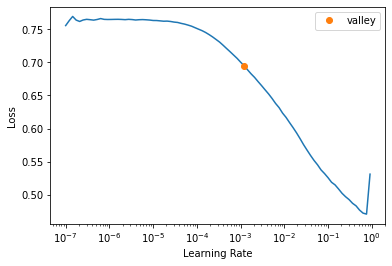

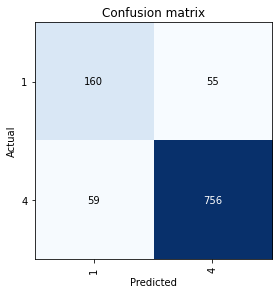

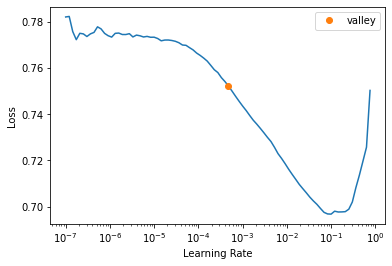

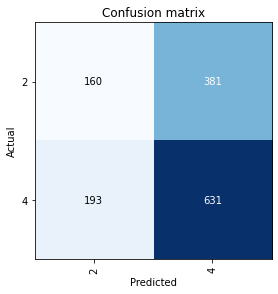

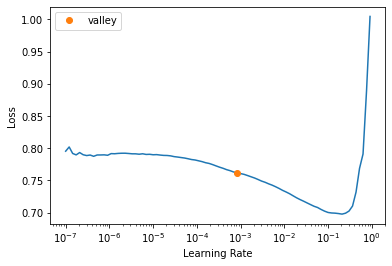

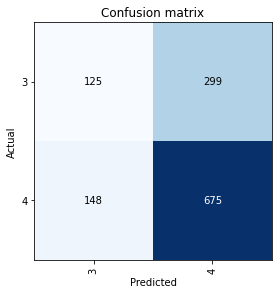

In [10]:
### df_1_4  -  df_2_4  -  df_3_4
final_epochs, metric, patience = 50, 'accuracy', 3
print("############### \n### df_1_4: ### \n###############")
learn, interp, splits = train(df_1_4, final_epochs, metric, patience, cat_names, cont_names, y_names)
print("\n############### \n### df_2_4: ###\n###############")
learn, interp, splits = train(df_2_4, final_epochs, metric, patience, cat_names, cont_names, y_names)
print("\n############### \n### df_3_4: ###\n###############")
learn, interp, splits = train(df_3_4, final_epochs, metric, patience, cat_names, cont_names, y_names)

4. Entrenamiento   1 vs all --> igual que el pto 3  -->  1vs2, 1vs3, 1vs4

############### 
### df_1_4: ### 
###############



Calculated Lrt:  0.0008317637839354575 using:  0.0001663527567870915


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.662902,0.683456,0.577670,0.704280,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.621451,0.672313,0.652427,0.737520,00:00
1,0.594172,0.657709,0.695146,0.767919,00:00
2,0.573291,0.643118,0.730097,0.786480,00:00



Learning Rate:  0.0008317637839354575


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.520272,0.628228,0.753398,0.802903,00:00
1,0.513910,0.604754,0.792233,0.825647,00:00
2,0.504746,0.582157,0.807767,0.835439,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.469325,0.522735,0.842718,0.841852,00:00
1,0.465718,0.409022,0.856311,0.845214,00:00
2,0.444051,0.351492,0.890291,0.845809,00:00
3,0.418708,0.333237,0.890291,0.838867,00:00
4,0.400967,0.333915,0.881553,0.819476,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.8418524201102167.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.444886,0.499117,0.853398,0.852055,00:00
1,0.437461,0.472376,0.858252,0.851644,00:00
2,0.428562,0.443055,0.860194,0.852868,00:00
3,0.423698,0.413510,0.866990,0.845004,00:00
4,0.416124,0.367393,0.886408,0.841625,00:00
5,0.406500,0.332057,0.900971,0.847335,00:00
6,0.398562,0.298717,0.904854,0.844576,00:00
7,0.387260,0.303682,0.884466,0.805693,00:00
8,0.374880,0.289273,0.903884,0.824875,00:00
9,0.361330,0.285592,0.900971,0.805684,00:00


Better model found at epoch 0 with accuracy value: 0.8533980846405029.
Better model found at epoch 3 with accuracy value: 0.8669902682304382.
Better model found at epoch 4 with accuracy value: 0.8864077925682068.
Better model found at epoch 5 with accuracy value: 0.9009708762168884.
No improvement since epoch 6: early stopping


              precision    recall  f1-score   support

           1       0.76      0.76      0.76       213
           4       0.94      0.94      0.94       817

    accuracy                           0.90      1030
   macro avg       0.85      0.85      0.85      1030
weighted avg       0.90      0.90      0.90      1030


############### 
### df_1_2: ###
###############



Calculated Lrt:  0.0005754399462603033 using:  0.00011508798925206066


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.763508,0.735754,0.203883,0.479046,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.712213,0.733623,0.214563,0.487565,00:00
1,0.688064,0.725134,0.259223,0.530385,00:00
2,0.658741,0.717382,0.343689,0.584742,00:00



Learning Rate:  0.0005754399462603033


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.591096,0.709900,0.404854,0.622740,00:00
1,0.584218,0.694112,0.509709,0.685994,00:00
2,0.570512,0.678958,0.580582,0.726254,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.535521,0.623429,0.725243,0.797277,00:00
1,0.505157,0.499038,0.836893,0.851562,00:00
2,0.475514,0.404836,0.866019,0.856466,00:00
3,0.448979,0.358924,0.874757,0.839281,00:00
4,0.431827,0.350122,0.875728,0.836115,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.7972771846437294.
Better model found at epoch 1 with balanced_accuracy_score value: 0.8515624531144039.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.432027,0.474689,0.842718,0.851412,00:00
1,0.427294,0.449495,0.848544,0.853147,00:00
2,0.418347,0.419051,0.862136,0.857822,00:00
3,0.409451,0.383446,0.868932,0.852622,00:00
4,0.404150,0.347992,0.876699,0.840487,00:00
5,0.396209,0.313581,0.885437,0.819533,00:00
6,0.387602,0.291905,0.894175,0.804233,00:00
7,0.378400,0.282860,0.890291,0.809358,00:00
8,0.369468,0.280185,0.893204,0.790439,00:00
9,0.359276,0.273173,0.894175,0.777851,00:00


Better model found at epoch 0 with accuracy value: 0.8427184224128723.
Better model found at epoch 2 with accuracy value: 0.8621359467506409.
Better model found at epoch 4 with accuracy value: 0.8766990303993225.
Better model found at epoch 6 with accuracy value: 0.8941747546195984.
No improvement since epoch 6: early stopping


              precision    recall  f1-score   support

           1       0.77      0.66      0.71       201
           4       0.92      0.95      0.94       829

    accuracy                           0.89      1030
   macro avg       0.84      0.80      0.82      1030
weighted avg       0.89      0.89      0.89      1030


############### 
### df_1_3: ###
###############



Calculated Lrt:  0.0010000000474974513 using:  0.00020000000949949026


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.747949,0.689032,0.520147,0.502699,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.698126,0.701965,0.453480,0.527592,00:00
1,0.687784,0.712020,0.409524,0.506086,00:00
2,0.680750,0.714741,0.415385,0.506990,00:00



Learning Rate:  0.0010000000474974513


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.667302,0.717195,0.430037,0.514486,00:00
1,0.664966,0.714367,0.452015,0.526712,00:00
2,0.661407,0.710131,0.468132,0.533125,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.648942,0.701489,0.526007,0.541562,00:00
1,0.666852,0.704497,0.539927,0.502969,00:00
2,0.665363,0.680980,0.594872,0.550222,00:00
3,0.657726,0.669097,0.610989,0.547800,00:00
4,0.650925,0.669629,0.617582,0.553235,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5415620867406148.
Better model found at epoch 4 with balanced_accuracy_score value: 0.5532345559064044.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.625445,0.668452,0.612454,0.547371,00:00
1,0.623822,0.667667,0.612454,0.546062,00:00
2,0.623162,0.671591,0.605861,0.538010,00:00
3,0.622281,0.678479,0.602198,0.537281,00:00


Better model found at epoch 0 with accuracy value: 0.6124542355537415.
No improvement since epoch 0: early stopping


              precision    recall  f1-score   support

           2       0.52      0.24      0.33       537
           4       0.63      0.85      0.73       828

    accuracy                           0.61      1365
   macro avg       0.58      0.55      0.53      1365
weighted avg       0.59      0.61      0.57      1365



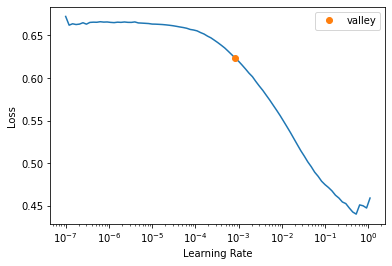

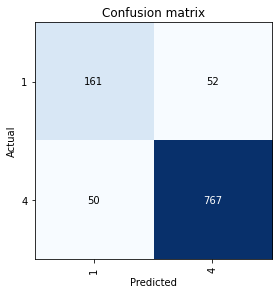

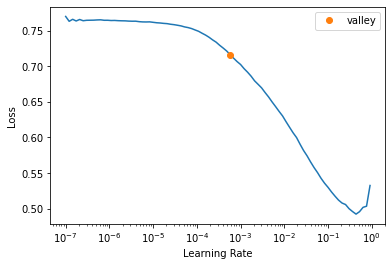

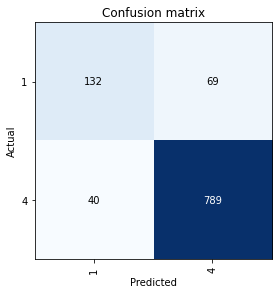

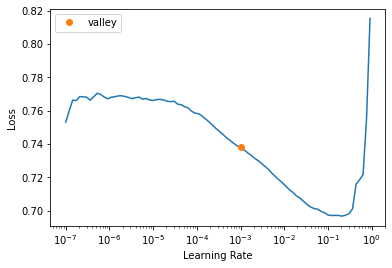

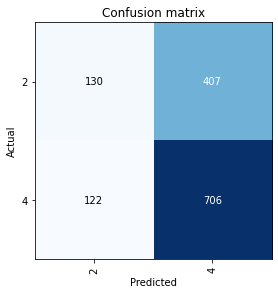

In [11]:
### df_1_4  -  df_1_2   -  df_1_3
# final_epochs, metric, patience = 200, 'accuracy', 3
print("############### \n### df_1_4: ### \n###############")
learn, interp, splits = train(df_1_4, final_epochs, metric, patience, cat_names, cont_names, y_names)
print("\n############### \n### df_1_2: ###\n###############")
learn, interp, splits = train(df_1_2, final_epochs, metric, patience, cat_names, cont_names, y_names)
print("\n############### \n### df_1_3: ###\n###############")
learn, interp, splits = train(df_1_3, final_epochs, metric, patience, cat_names, cont_names, y_names)

In [12]:
torch.cuda.reset_max_memory_allocated()

/home/javier/pyenvs/tennis/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Getting base error


Calculating Permutation Importance


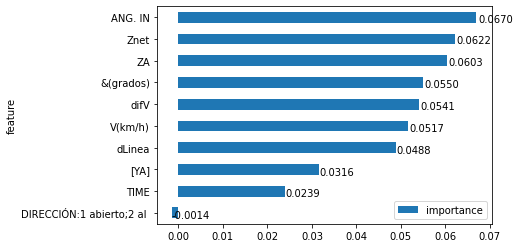

In [13]:
### FEATURE IMPORTANCE:
class PermutationImportance():
    "Calculate and plot the permutation importance"
    def __init__(self, learn:Learner, df=None, bs=None):
        "Initialize with a test dataframe, a learner, and a metric"
        self.learn = learn
        self.df = df
        bs = bs if bs is not None else learn.dls.bs
        if self.df is not None:
            self.dl = learn.dls.test_dl(self.df, bs=bs)
        else:
            self.dl = learn.dls[1]
        self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
        self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
        self.y = learn.dls.y_names
        self.results = self.calc_feat_importance()
        self.plot_importance(self.ord_dic_to_df(self.results))
    
    def measure_col(self, name:str):
        "Measures change after column shuffle"
        col = [name]
        if f'{name}_na' in self.na: col.append(name)
        orig = self.dl.items[col].values
        perm = np.random.permutation(len(orig))
        self.dl.items[col] = self.dl.items[col].values[perm]
        metric = learn.validate(dl=self.dl)[1]
        self.dl.items[col] = orig
        return metric
    
    def calc_feat_importance(self):
        "Calculates permutation importance by shuffling a column on a percentage scale"
        print('Getting base error')
        base_error = self.learn.validate(dl=self.dl)[1]
        self.importance = {}
        pbar = progress_bar(self.x_names)
        print('Calculating Permutation Importance')
        for col in pbar:
            self.importance[col] = self.measure_col(col)
        for key, value in self.importance.items():
            self.importance[key] = (base_error-value)/base_error #this can be adjusted
        return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))
    
    def ord_dic_to_df(self, dict:OrderedDict):
        return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])
    
    def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
        "Plot importance with an optional limit to how many variables shown"
        df_copy = df.copy()
        df_copy['feature'] = df_copy['feature'].str.slice(0,25)
        df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
        ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
        for p in ax.patches:
            ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

y_val = df_1_2_3_vs_4.iloc[splits[1]].Efectividad.values
X_val = df_1_2_3_vs_4.iloc[splits[1]][['DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T','V(km/h)','[YA]','ZA','Znet','TIME','difV','&(grados)','ANG. IN','dLinea']].values            
            
res = PermutationImportance(learn, df_1_3.iloc[splits[0]], bs=64)

Getting base error


Calculating Permutation Importance


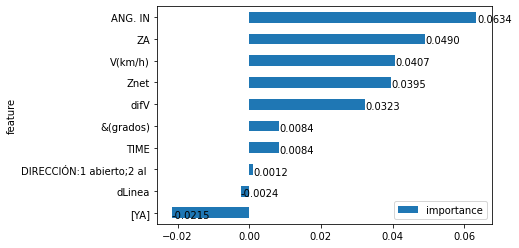

In [14]:
res = PermutationImportance(learn)

In [15]:
# torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [16]:
res = PermutationImportance(learn, df_1_2_3_vs_4.iloc[splits[1]], bs=64)

Getting base error


/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:247: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/sr

RuntimeError: Exception occured in `Recorder` when calling event `after_batch`:
	CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
torch.cuda.is_available(),torch.cuda.device_count(), torch.cuda.get_device_name()

In [ ]:
torch.cuda.get_device_properties(torch.cuda.device), torch.cuda.mem_get_info()

In [ ]:
torch.cuda.memory_snapshot()

In [ ]:
y_val = df_1_2_3_vs_4.iloc[splits[1]].Efectividad.values
X_val = df_1_2_3_vs_4.iloc[splits[1]][['DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T','V(km/h)','[YA]','ZA','Znet','TIME','difV','&(grados)','ANG. IN','dLinea']].values

In [19]:
learn.dls

In [21]:
res.importance

{'DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T': -0.0020120080476500974,
 'V(km/h)': 0.01408453395023578,
 '[YA]': 0.009557396438851786,
 'ZA': 0.02162982681810045,
 'Znet': 0.024144860758497325,
 'TIME': 0.03923544649422667,
 'difV': 0.023641834865750548,
 '&(grados)': 0.015090585735729339,
 'ANG. IN': 0.019617723247113333,
 'dLinea': 0.018108645568872993}

_______________________________________

## Me quedé aquí (9-nov-2022):
_______________________________________

In [ ]:
# learn.validate()

## Conclusiones:
1. Después de entrenar diferentes modelos para deuce y ad, vemos que entrenando los 4 modelos el resultado no es muy bueno. Sin embargo entrenando de 2
en dos sale mucho mejor.  

    1.1. A parte veo que los datos no representan todas las opciones posibles, puesto que no están los que tenían efectividad 0 en el dataset BKG_Corregido. Únicamente se ha tenido en cuenta cuando gana el sacador. Faltarían datos de cuando gana el restador.  

    1.2. Pensar mejor cómo proceder y si es necesario tener todos los datos para el entrenamiento.

2. Ver qué opciones da FastAI para interpretar el modelo xAI

## Pruebas:
1. Entrenar con 1,2,3 vs 4.
2. Entrenar 2 vs 3,4
3. 1vs4,  2vs4, 3vs4  (4 vs all)
4. 1vs all --> igual que el pto 3  -->  1vs2, 1vs3, 1vs4